### TensorFlow 2 Object Detection API
Tutorial:
https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

Example: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_checkpoint.html

`visualization_utils.py` was customized.
We need comment out rows:
 > `#import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements` <br>
 > `#import matplotlib.pyplot as plt  # pylint: disable=g-import-not-at-top`
 
In `visualize_boxes_and_labels_on_image_array` function added attr `font_size`

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import pathlib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

import numpy as np
from PIL import Image, ImageFont
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
PATH_TO_MODEL_DIR = os.path.join('c:', os.sep, 'Users', 'User', '.keras', 'datasets', 'centernet_hg104_1024x1024_coco17_tpu-32')
PATH_TO_LABELS = os.path.join('c:', os.sep, 'Users', 'User', '.keras', 'datasets', 'mscoco_label_map.pbtxt')
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

In [3]:
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

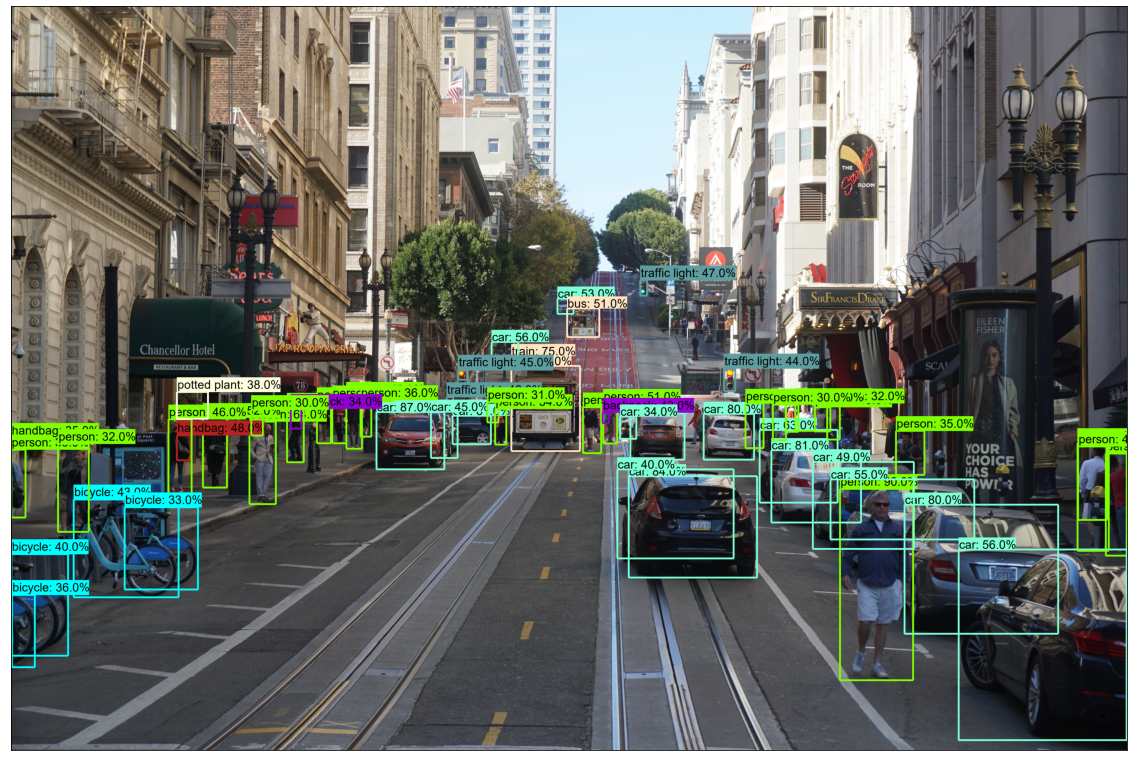

In [4]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
image_np = np.array(Image.open('test.jpg'))
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1000,
        min_score_thresh=.3,
        line_thickness=10,
        agnostic_mode=False,
        font_size=64)

plt.figure(figsize=(20,15))
plt.imshow(image_np_with_detections)
plt.xticks([]);plt.yticks([])
plt.show()